# Evaluating Miami-Dade Transit’s On-time Performance

Author: Anran Zheng

We conducted an analysis of Miami-Dade Transit’s on-time performance using GTFS static data as well as data acquired from the Swiftly API from October 2022 to March 2023. During this period, there are 99 routes running in total, including Metrorail, trolleys, Metromovers, and transit buses. We computed the daily service time for each route and the daily number of transit vehicles serving each transit stop to understand the transit service supply. We applied two measurements for analyzing the on-time performance of transit vehicles: arrival time difference and headway difference. 

In [2]:
import http.client
import pandas as pd
import os, glob
from datetime import datetime
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt
import seaborn
from shapely.geometry import Point

In [3]:
path = "C:/Users/anranzheng/Dropbox (UFL)/ML proj/Bus Delay Prediction/Miami/code/headway cal result"

#merge all the data: 5 min
all_files = glob.glob(os.path.join(path, "*.csv"))

df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
df_merged   = pd.concat(df_from_each_file, ignore_index=True)
df_merged=df_merged.drop_duplicates()

df_merged=df_merged[['id2_x', 'interval2', 'rank2', 'id3_x', 'interval2s',
       'block_id', 'trip_id', 'route_id', 'route_short_name', 'direction_id',
       'stop_id', 'stop_name', 'headsign', 'vehicle_id', 'driver_id',
       'gtfs_stop_seq', 'start_time', 'sched_adherence_secs', 'scheduled_date',
       'scheduled_time', 'actual_date', 'actual_time', 'is_arrival',
       'timestamp', 'scheduled', 'id2_y', 'id3_y', 'wk', 'hourOfTimestamp1',
       'hourOfTimestamp2', 'headway_diff']]

df_merged.shape

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3592423999.py:6: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3592423999.py:6: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3592423999.py:6: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3592423999.py:6: DtypeWarning: Columns (9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_from_each_file = (pd.read_csv(f, sep=',') for f in all_files)
C:\Users\anranzheng\AppData\Local\Te

(47786436, 31)

On-time performance data provides schedule-adherence information on all routes in the system (e.g., scheduled arrival time, actual arrival time, and their arrival time differences). This dataset also includes detailed trip information such as arrival stops, vehicle ID, bus routes, direction, trip destination, stop sequence, as well as status (delay or not). 

In [4]:
#convert all the route_short_name into number 
df_merged['route_short_name']= df_merged['route_short_name'].map(str)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47786436 entries, 0 to 47786435
Data columns (total 31 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id2_x                 object 
 1   interval2             float64
 2   rank2                 float64
 3   id3_x                 object 
 4   interval2s            float64
 5   block_id              float64
 6   trip_id               float64
 7   route_id              float64
 8   route_short_name      object 
 9   direction_id          float64
 10  stop_id               float64
 11  stop_name             object 
 12  headsign              object 
 13  vehicle_id            object 
 14  driver_id             float64
 15  gtfs_stop_seq         float64
 16  start_time            object 
 17  sched_adherence_secs  float64
 18  scheduled_date        object 
 19  scheduled_time        object 
 20  actual_date           object 
 21  actual_time           object 
 22  is_arrival            bool   
 23  times

# Measurement 1: Arrival time difference

We then evaluated on-time performance by first measuring the difference between scheduled and actual arrival time (to be termed as arrival time difference). This measure reflects the experience of passengers who checks the train/bus schedule. We conducted the on-time performance on route level by routes, day of time, weekday or weekend, and different route types. 

## Arrival time difference by time of day and by weekday/weekend

To analyze when delay or early arrivals happen for each route, we generated pivot tables showing the mean arrival time differences by route and hour in Figure 12. The pivot table can summarize the on-time performance dataset by grouping and aggregating the arrival time differences by hour and route. The x-axis shows the hour of day, and the Y-axis shows the route_id. The average arrival time difference is filled at the cells. As the colormap on the right shows, red zones denote that the buses have been delayed on average for more than 20 minutes. Orange zones represent the bus delayed on average for 15-20 minutes and yellow zones for 5-10 minutes. Cyan zones (lighter color zones) represent very small arrival and actual time differences and suggest that the buses perform on-time. Blue zones represent early arrival at 5-10 minutes. For each route, having more cells in with lighter color (cyan zones) indicates better on-time performance. The Figure 12 shows that weekdays tend to have more and longer delayed trips than weekends, and transit vehicles frequently arrival early during the weekends. Transit vehicles often delay for over 20 minutes during afternoon peak hours (4-7pm) especially on weekdays. 

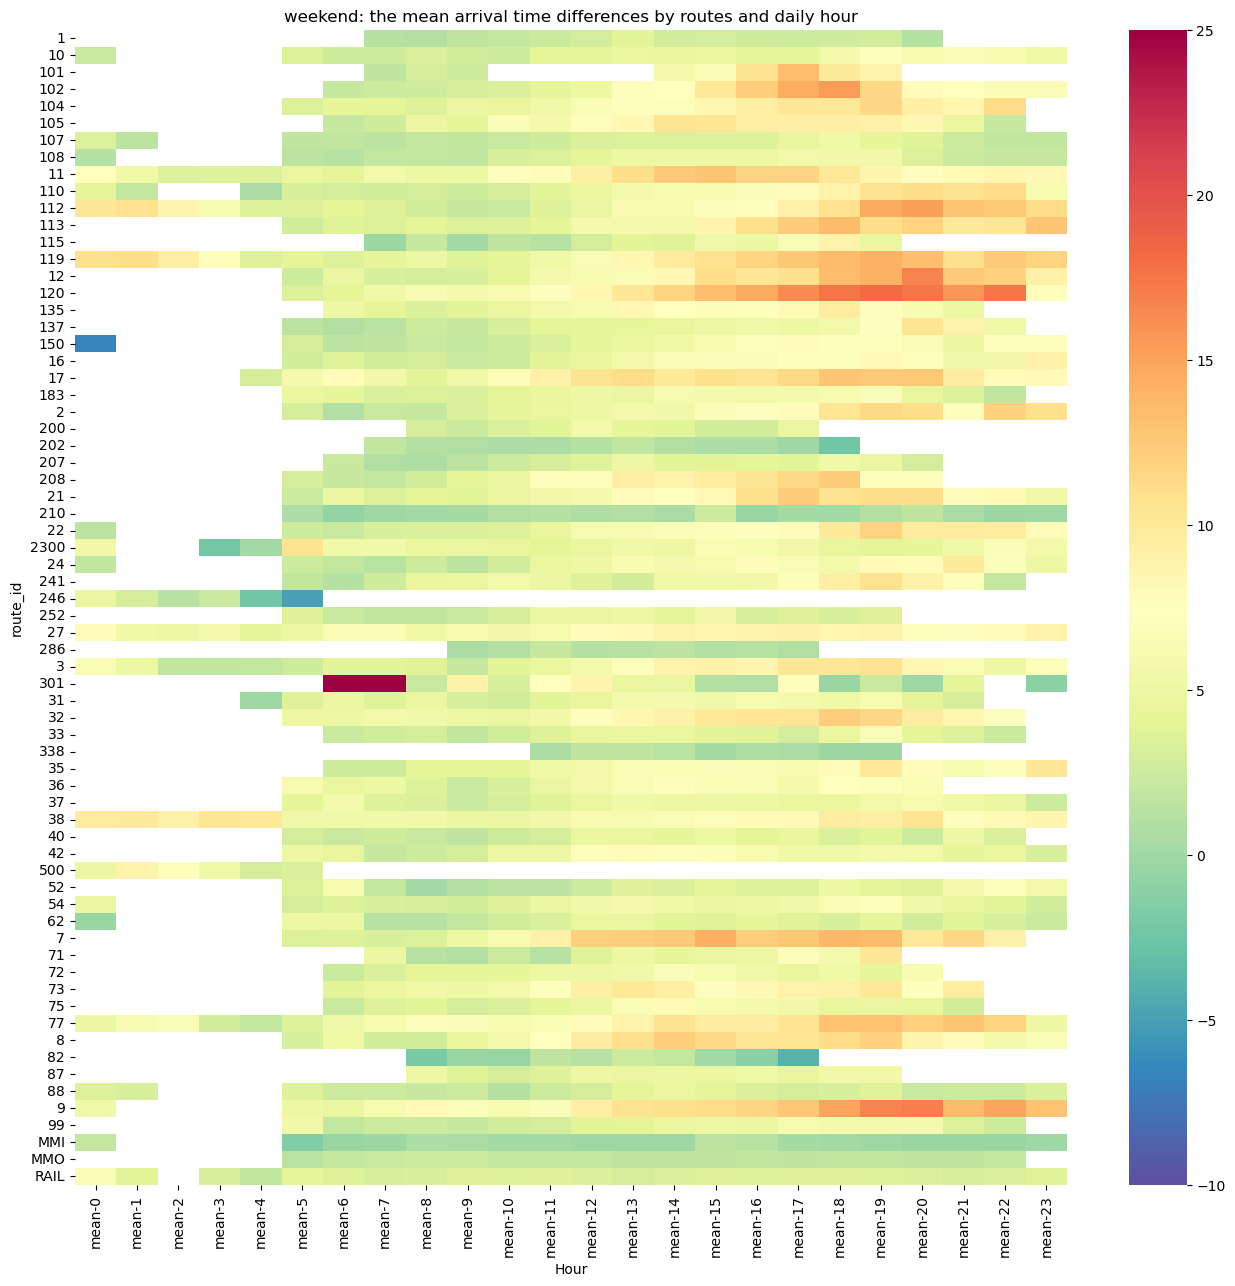

In [5]:
df5=df_merged

df5["sched_adherence_min"]=df5["sched_adherence_secs"]/60

weekend=df5[df5['wk']=='Weekend']
weekday=df5[df5['wk']=='Weekday']

#schedule 
plt.figure(figsize=(16,15))
schedule = weekend.pivot_table(index=weekend.route_short_name, columns=weekend.hourOfTimestamp2, aggfunc=[np.mean],values="sched_adherence_min")
seaborn.heatmap(schedule, cmap="Spectral_r", vmin=-10, vmax=25)
plt.title('weekend: the mean arrival time differences by routes and daily hour')
plt.xlabel('Hour')
plt.ylabel('route_id')
plt.savefig('Figure 12. pivot table of mean arrival time differences by routes and daily hour by weekend.png')
plt.show() 


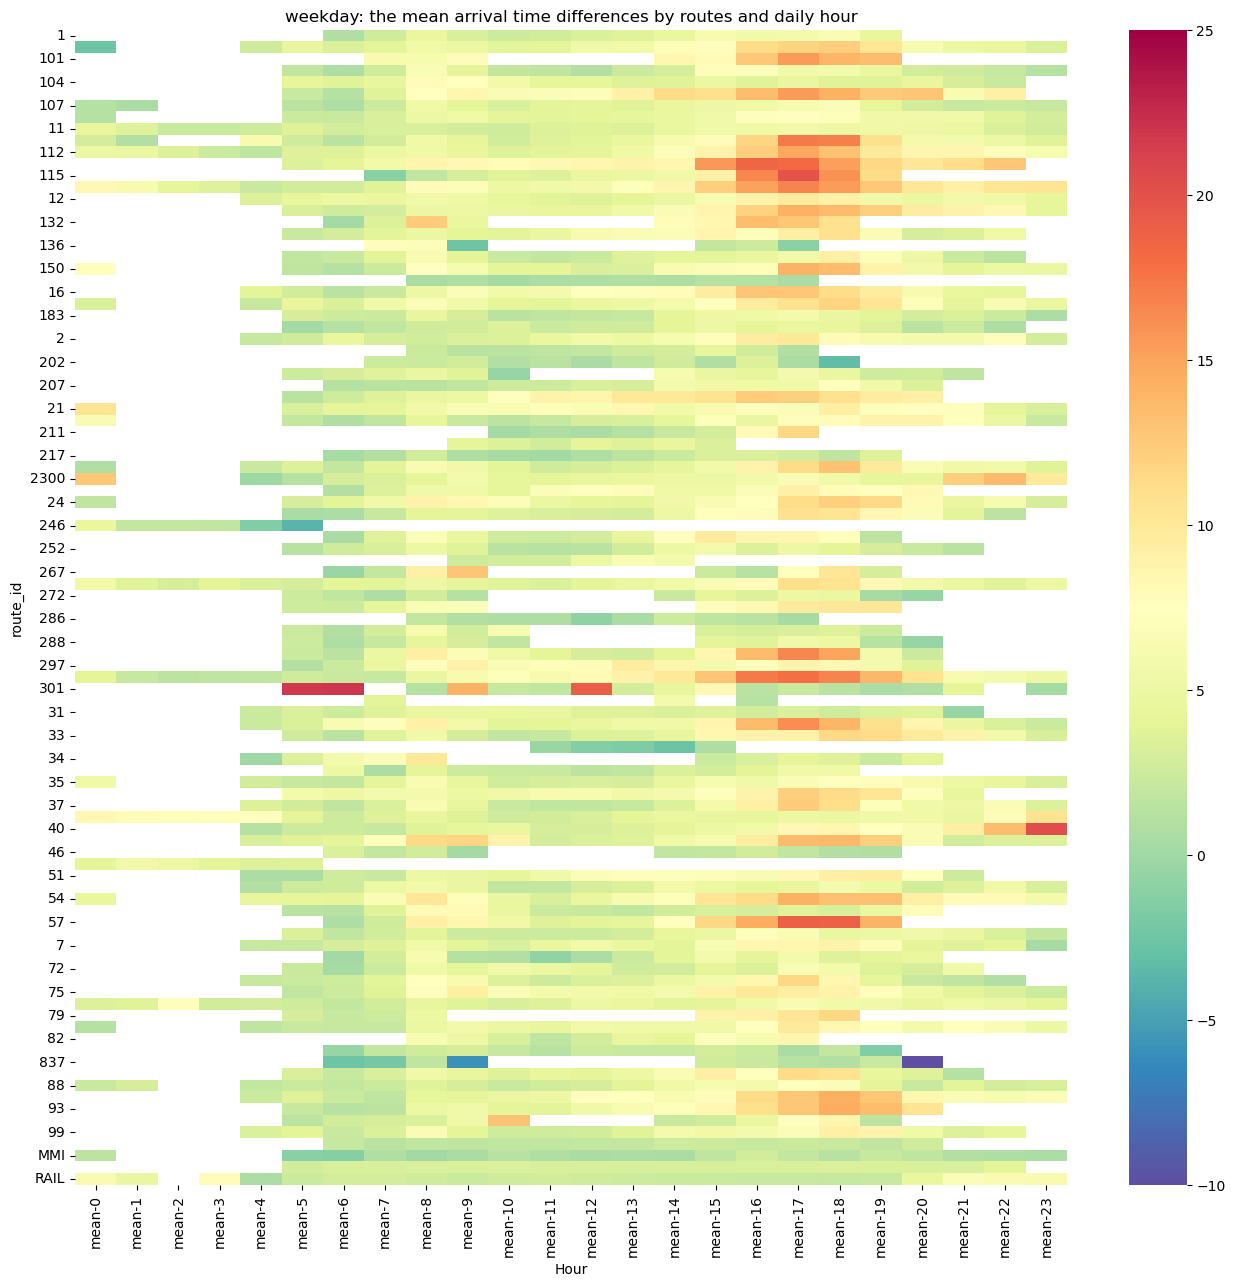

In [6]:
plt.figure(figsize=(16,15))
schedule = weekday.pivot_table(index=weekday.route_short_name, columns=weekday.hourOfTimestamp2, aggfunc=[np.mean],values="sched_adherence_min")
seaborn.heatmap(schedule, cmap="Spectral_r", vmin=-10, vmax=25)
plt.title('weekday: the mean arrival time differences by routes and daily hour')
plt.xlabel('Hour')
plt.ylabel('route_id')
plt.savefig('Figure 12. pivot table of mean arrival time differences by routes and daily hour by weekdays.png')
plt.show() 


## Arrival time difference by routes

We visualize the distribution of the arrival time difference across transit routes using a boxplot in Figure 7. The median line of each box represents the median arrival time difference for all trips of a transit route. The length of the “box” for each transit route indicates the variation in arrival time difference; the longer a box is, the more uncertain the arrival time. The horizontal red line denotes the 0 value of arrival time difference, which is compared with the median value of each ‘box’. Ideally, the median arrival time difference should be close to the red line. Transit routes such as Route 286 and Route 155 have an arrival time difference close to zero and a low variation in arrival time, which means that they have the best on-time performance. By contrast, the worst performing transit routes are routes 302, 29, and 57. The arrival time of these routes fluctuates a lot, with a high frequency of delays. 

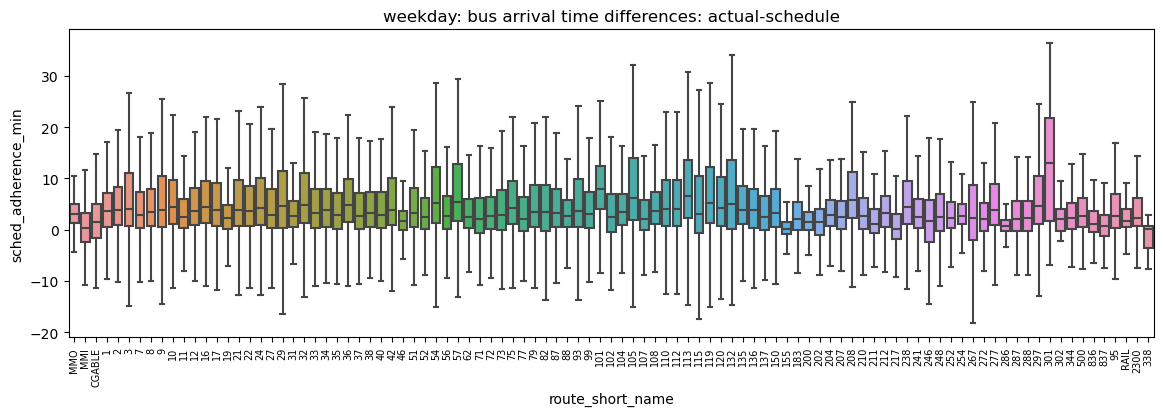

In [7]:
plt.figure(figsize=(14,4))
seaborn.boxplot(x="route_short_name", y="sched_adherence_min", data=weekday, showfliers = False)
plt.title("weekday: bus arrival time differences: actual-schedule")
locs, labels = plt.xticks()
plt.xticks(rotation=90,fontsize=7)
plt.savefig('Figure 7. The arrival time difference and arrival uncertainties of all transit routes (weekdays).png')

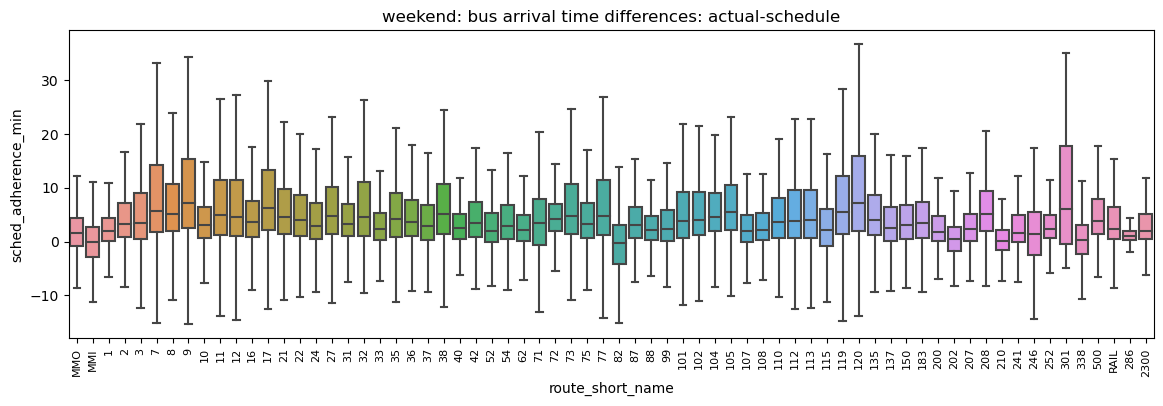

In [8]:
plt.figure(figsize=(14,4))
seaborn.boxplot(x="route_short_name", y="sched_adherence_min", data=weekend, showfliers = False)
plt.title("weekend: bus arrival time differences: actual-schedule")
locs, labels = plt.xticks()
plt.xticks(rotation=90,fontsize=8)
plt.savefig('Figure 7. The arrival time difference and arrival uncertainties of all transit routes (weekend).png')

## Top/worst 10 on-time routes

In [9]:
weekend_mean=weekend.groupby(['route_short_name'])['sched_adherence_min'].mean().reset_index()

#the shortest service hour
weekend_mean.sort_values("sched_adherence_min",inplace=True,ascending = False)

weekend_mean.head(10)

,route_short_name,sched_adherence_min
15,120,10.806780
63,9,10.249863
53,7,9.667960
20,17,9.136073
13,119,8.554957
38,301,8.457903
58,77,8.341773
8,11,7.963869
14,12,7.917342
59,8,7.903514


In [10]:
weekend_mean.tail(10).sort_values("sched_adherence_min",ascending = True)

,route_short_name,sched_adherence_min
60,82,0.032711
65,MMI,0.127368
28,210,0.502840
24,202,0.702990
42,338,0.730028
36,286,1.227451
33,246,1.386492
66,MMO,1.905345
0,1,2.384940
62,88,2.977593


In [11]:
weekday_mean=weekday.groupby(['route_short_name'])['sched_adherence_min'].mean().reset_index()

#the shortest service hour
weekday_mean.sort_values("sched_adherence_min",inplace=True,ascending = False)

weekday_mean.head(10)

,route_short_name,sched_adherence_min
56,301,12.494201
11,113,9.965042
2,101,9.754321
5,105,9.415164
16,132,9.092791
13,119,8.611237
76,57,8.602885
74,54,8.150097
55,3,8.061557
31,208,7.986505


In [12]:
weekday_mean.tail(10).sort_values("sched_adherence_min",ascending = True)

,route_short_name,sched_adherence_min
61,338,-1.452859
88,837,0.296676
21,155,0.700338
96,MMI,0.887149
50,286,1.022668
42,246,1.518000
28,202,1.596245
36,217,1.705076
87,836,1.879823
95,CGABLE,1.987227


## number of bus at peak time

In [13]:
peak_hr=[6,7,8,9,16,17,18,19]
weekday_pk=weekday[weekday['hourOfTimestamp1'].isin(peak_hr)]
weekend_pk=weekend[weekend['hourOfTimestamp1'].isin(peak_hr)]

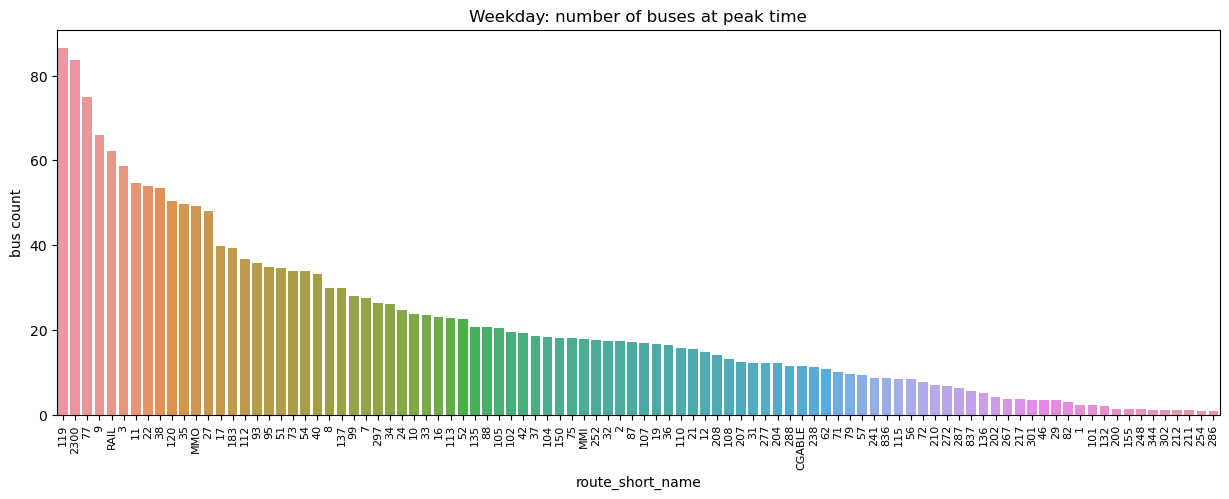

In [15]:
weekday_pk1=weekday_pk.groupby(['actual_date','route_short_name'])['vehicle_id'].nunique().reset_index()
weekday_pk2=weekday_pk1.groupby(['route_short_name'])['vehicle_id'].mean().reset_index()

plt.figure(figsize=(15,5))
seaborn.barplot(y="vehicle_id", x="route_short_name", data=weekday_pk2, order=weekday_pk2.sort_values(by=['vehicle_id'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('bus count')
plt.title('Weekday: number of buses at peak time')
plt.savefig('Figure 6. number of buses during peak times (weekdays).png')

In [16]:
weekday_pk2.sort_values("vehicle_id",inplace=True,ascending = False)

weekday_pk2.head(10)

,route_short_name,vehicle_id
13,119,86.476923
38,2300,83.700000
80,77,74.969231
88,9,66.092308
95,RAIL,62.258333
54,3,58.669231
8,11,54.723077
37,22,53.884615
65,38,53.488372
15,120,50.346154


In [17]:
weekday_pk2.tail(10)

,route_short_name,vehicle_id
16,132,2.000000
27,200,1.378378
21,155,1.344000
42,248,1.320513
61,344,1.170213
56,302,1.090909
35,212,1.067308
34,211,1.037383
44,254,1.020000
49,286,1.012346


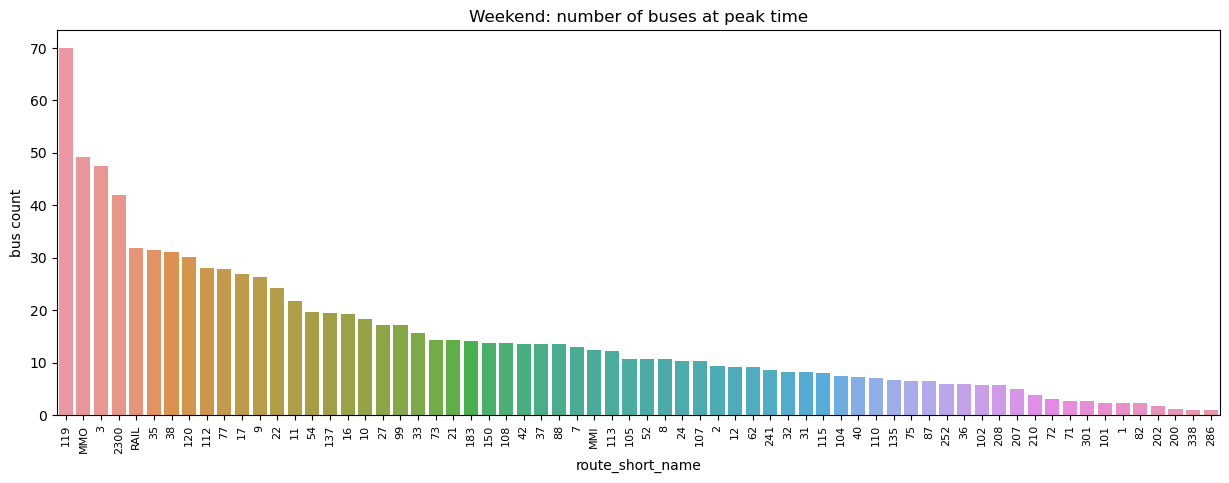

In [18]:
weekend_pk1=weekend_pk.groupby(['actual_date','route_short_name'])['vehicle_id'].nunique().reset_index()
weekend_pk2=weekend_pk1.groupby(['route_short_name'])['vehicle_id'].mean().reset_index()

plt.figure(figsize=(15,5))
seaborn.barplot(y="vehicle_id", x="route_short_name", data=weekend_pk2, order=weekend_pk2.sort_values(by=['vehicle_id'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('bus count')
plt.title('Weekend: number of buses at peak time')
plt.savefig('Figure 6. number of buses during peak times (weekend).png')

In [19]:
weekend_pk2.sort_values("vehicle_id",inplace=True,ascending = False)

weekend_pk2.head(10)

,route_short_name,vehicle_id
13,119,69.884615
64,MMO,49.270833
36,3,47.500000
30,2300,42.000000
65,RAIL,31.854167
42,35,31.519231
45,38,31.173077
15,120,30.153846
10,112,27.980769
56,77,27.807692


In [20]:
weekend_pk2.tail(10)

,route_short_name,vehicle_id
53,72,3.137255
52,71,2.750000
37,301,2.666667
2,101,2.365385
0,1,2.320000
58,82,2.269231
24,202,1.823529
23,200,1.071429
41,338,1.019608
35,286,1.000000


## How many buses are needed for X wait time on each route

In [22]:
#read route length file
rt_len=pd.read_excel('C://Users//anranzheng//Dropbox (UFL)//ML proj//Bus Delay Prediction//Miami//miami data//rt len.xlsx')
rt_len2=rt_len.groupby('route_shor')['rt_len'].mean().reset_index()
rt_len2=rt_len2[rt_len2['route_shor'].map(str).isin(list(df5['route_short_name'].unique()))]

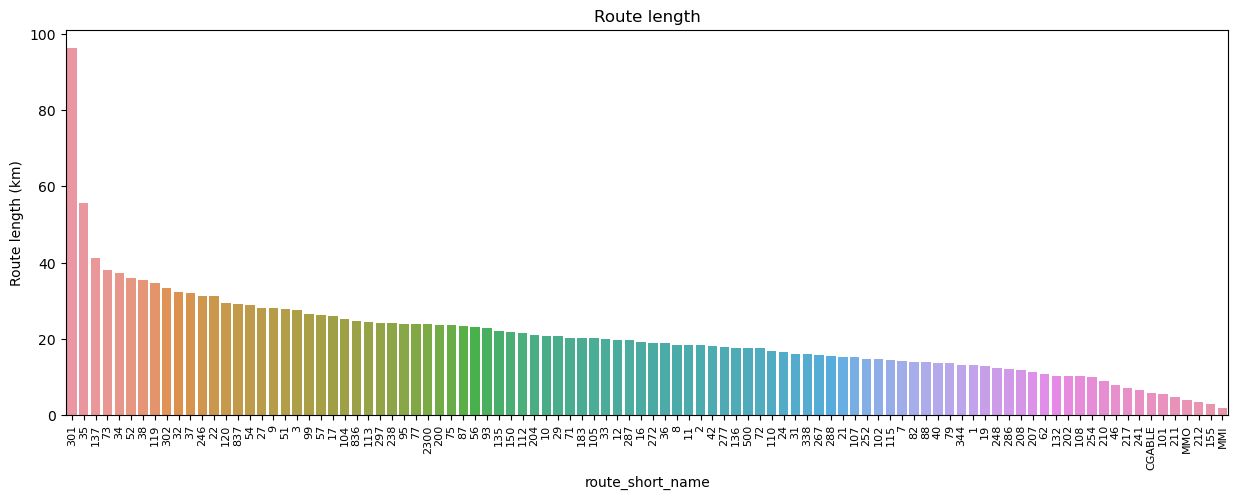

In [25]:
plt.figure(figsize=(15,5))
seaborn.barplot(y="rt_len", x="route_shor", data=rt_len2, order=rt_len2.sort_values(by=['rt_len'], ascending=False).set_index('route_shor').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Route length (km)')
plt.xlabel('route_short_name')
plt.title('Route length')
plt.savefig('Figure 10. Route length.png')

categorize the proportion:
- arrive on time (time difference +- 2min)
- 5-10 min late
- 10-30 min late
- 30 min + late

run the code below: categorize 

In [27]:
# categorize into the following six groups: early, on time, 2-5 min late, 5-10 min late, 10-30 min late, 30+
df5= pd.concat([df5,pd.DataFrame(columns=['status1'])], sort=False)

df5['status1'][df5['sched_adherence_min']<-2]='early'
df5['status1'][(df5['sched_adherence_min']>=-2)&(df5['sched_adherence_min']<=2)]='on time'
df5['status1'][(df5['sched_adherence_min']>2)&(df5['sched_adherence_min']<=5)]='2-5 min late'
df5['status1'][(df5['sched_adherence_min']>5)&(df5['sched_adherence_min']<=10)]='5-10 min late'
df5['status1'][(df5['sched_adherence_min']>10)&(df5['sched_adherence_min']<=30)]='10-30 min late'
df5['status1'][df5['sched_adherence_min']>30]='30+ min late'

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3041897357.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['status1'][df5['sched_adherence_min']<-2]='early'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3041897357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['status1'][(df5['sched_adherence_min']>=-2)&(df5['sched_adherence_min']<=2)]='on time'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3041897357.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

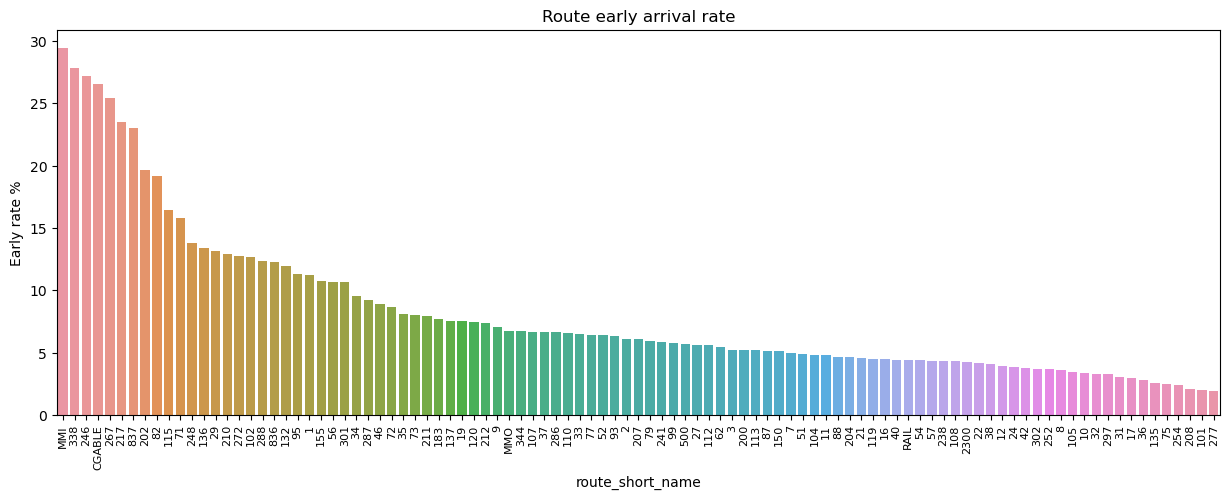

In [28]:
early=df5[df5['status1']=='early']

#total number of vehs
veh_num=df5.groupby(['route_short_name','actual_date','trip_id'])['stop_id'].nunique().reset_index()
#veh_num2=veh_num.groupby(['route_short_name'])['vehicle_id'].mean().reset_index()

veh_num2=veh_num.groupby(['route_short_name'])['stop_id'].sum().reset_index()

early2=early.groupby(['route_short_name','actual_date','trip_id'])['stop_id'].nunique().reset_index()
early3=early2.groupby(['route_short_name'])['stop_id'].sum().reset_index()
early_merge=veh_num2.merge(early3, on='route_short_name',how='left')
early_merge['early_rate']=early_merge['stop_id_y']*100/early_merge['stop_id_x']

plt.figure(figsize=(15,5))
seaborn.barplot(y="early_rate", x="route_short_name", data=early_merge, order=early_merge.sort_values(by=['early_rate'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Early rate %')
plt.title('Route early arrival rate')
plt.savefig('Figure 8. Route early arrival rate.png')

on-time

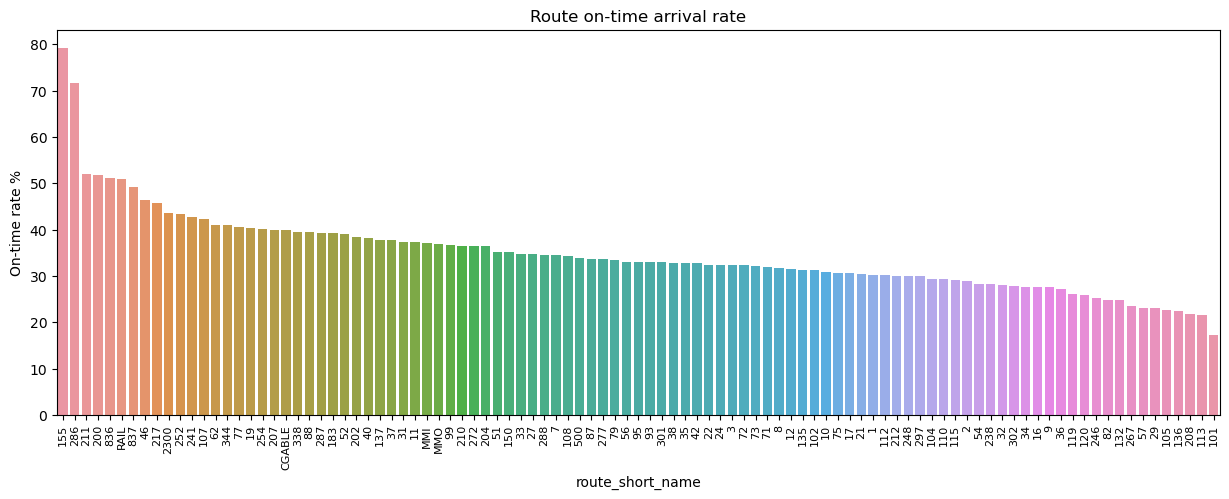

In [29]:
early=df5[df5['status1']=='on time']

early2=early.groupby(['route_short_name','actual_date','trip_id'])['stop_id'].nunique().reset_index()
early3=early2.groupby(['route_short_name'])['stop_id'].sum().reset_index()
early_merge=veh_num2.merge(early3, on='route_short_name',how='left')
early_merge['early_rate']=early_merge['stop_id_y']*100/early_merge['stop_id_x']

plt.figure(figsize=(15,5))
seaborn.barplot(y="early_rate", x="route_short_name", data=early_merge, order=early_merge.sort_values(by=['early_rate'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('On-time rate %')
plt.title('Route on-time arrival rate')

plt.savefig('Figure 8. Route on-time arrival rate.png')

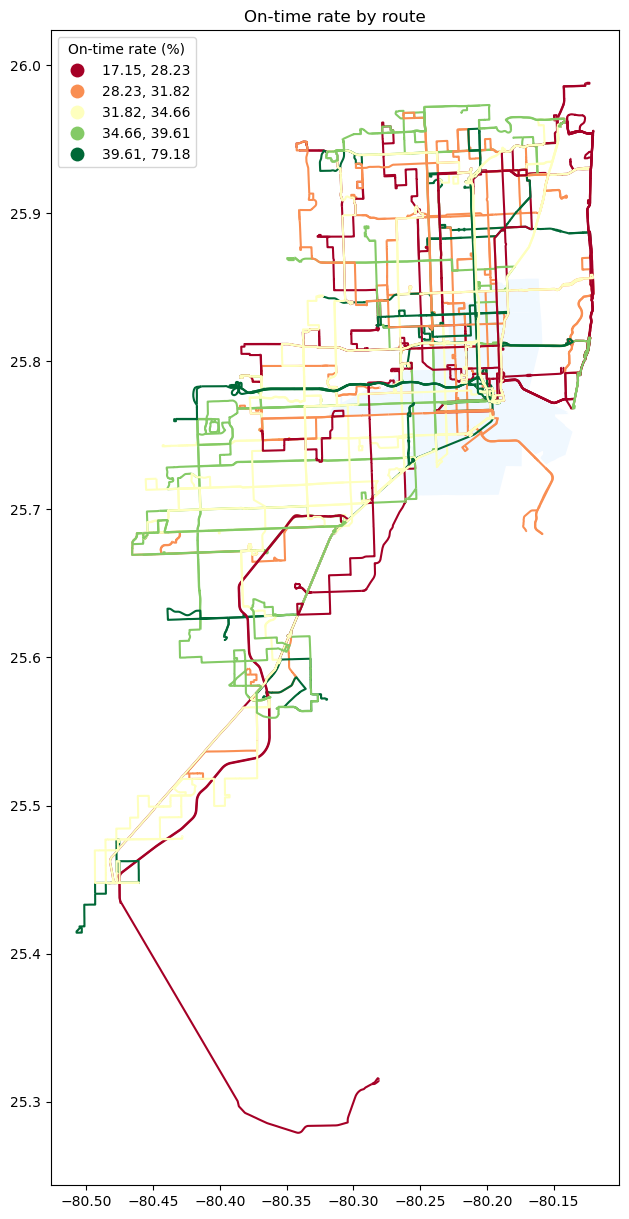

In [31]:
route= gpd.read_file('C:/Users/anranzheng/Downloads/miami Bus_Route/Bus_Route.shp')
new_df = pd.merge(early_merge, route,  how='left', left_on=['route_short_name'], right_on = ['LINEABBR']).dropna()
new_df = pd.merge(route, early_merge, how='left', left_on=['LINEABBR'], right_on = ['route_short_name']).dropna()
new_df=new_df.drop(new_df[new_df.LINEABBR =='301'].index)

from matplotlib.legend_handler import HandlerLine2D

#create spatial distribution of delays
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
leg_args = {'loc': 'upper left','title':'On-time rate (%)'}

jax_boundary= gpd.read_file('C:/Users/anranzheng/Downloads/Miami_City_District/Miami_City_District.shp')
jax_boundary.plot(ax=ax, color='aliceblue', label='boundary')
#route.plot(ax=ax, color='grey', label='route', linewidth=0.1)
new_df.plot(ax=ax, marker='o', column='early_rate', legend_kwds=leg_args,legend=True, cmap='RdYlGn', scheme="Quantiles")
#plt.title('Early arrival rate at Transit stops at Weekend (%)')

#ax.legend(loc='upper right') 
plt.title('On-time rate by route')
plt.savefig('On-time rate by route.png')

2-5 min late

In [32]:
early=df5[df5['status1']=='2-5 min late']

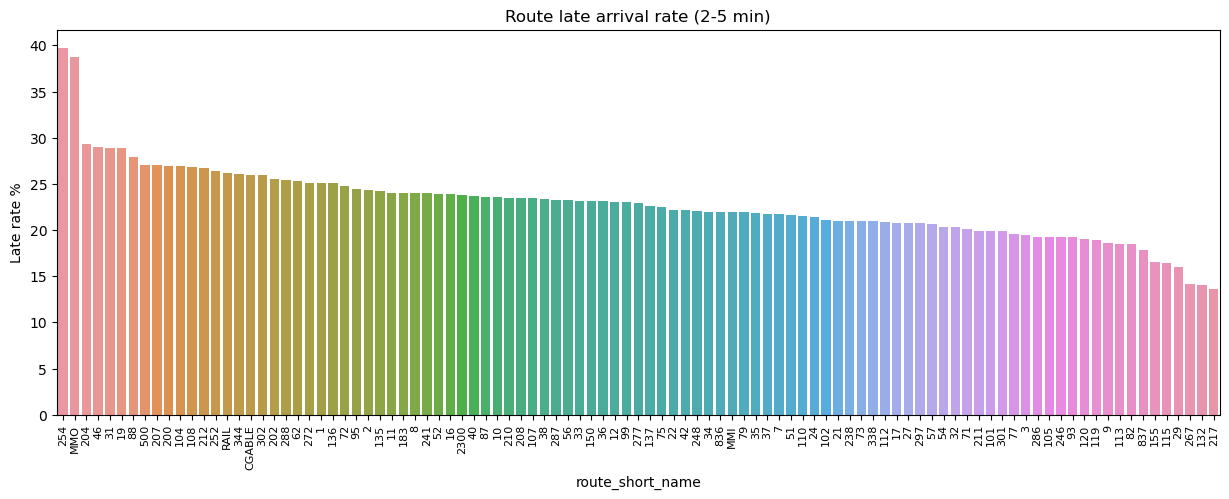

In [33]:
early2=early.groupby(['route_short_name','actual_date','trip_id'])['stop_id'].nunique().reset_index()
early3=early2.groupby(['route_short_name'])['stop_id'].sum().reset_index()
early_merge=veh_num2.merge(early3, on='route_short_name',how='left')
early_merge['early_rate']=early_merge['stop_id_y']*100/early_merge['stop_id_x']

plt.figure(figsize=(15,5))
seaborn.barplot(y="early_rate", x="route_short_name", data=early_merge, order=early_merge.sort_values(by=['early_rate'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Late rate %')
plt.title('Route late arrival rate (2-5 min)')

plt.savefig('Figure 8. Route 2-5 min late arrival rate.png')

5-10 min late

In [34]:
early=df5[df5['status1']=='5-10 min late']

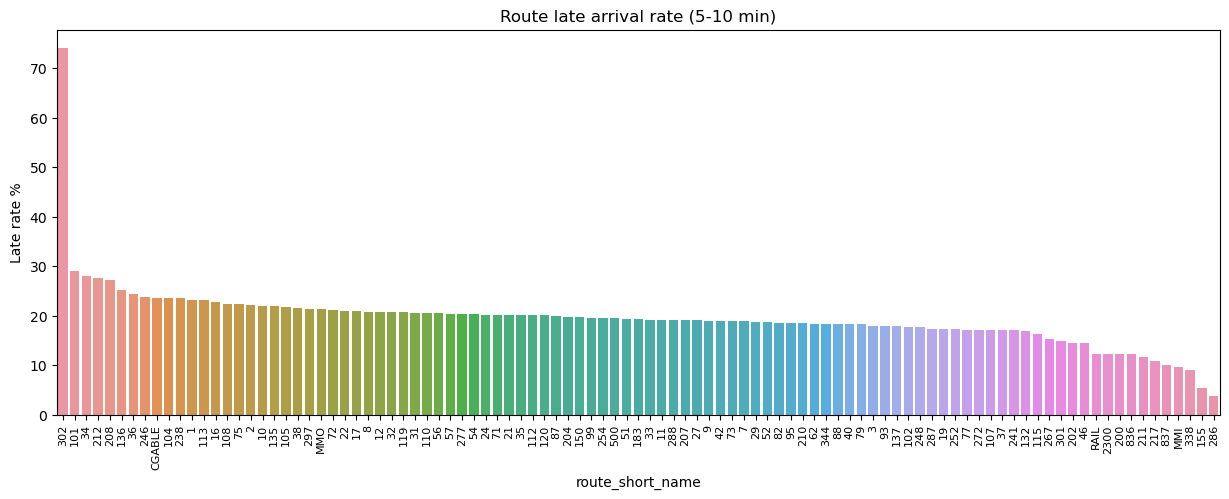

In [35]:
early2=early.groupby(['route_short_name','actual_date','trip_id'])['stop_id'].nunique().reset_index()
early3=early2.groupby(['route_short_name'])['stop_id'].sum().reset_index()
early_merge=veh_num2.merge(early3, on='route_short_name',how='left')
early_merge['early_rate']=early_merge['stop_id_y']*100/early_merge['stop_id_x']

plt.figure(figsize=(15,5))
seaborn.barplot(y="early_rate", x="route_short_name", data=early_merge, order=early_merge.sort_values(by=['early_rate'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Late rate %')
plt.title('Route late arrival rate (5-10 min)')
plt.savefig('Figure 8. Route 5-10 min late arrival rate.png')

10-30 min late

In [36]:
early=df5[df5['status1']=='10-30 min late']

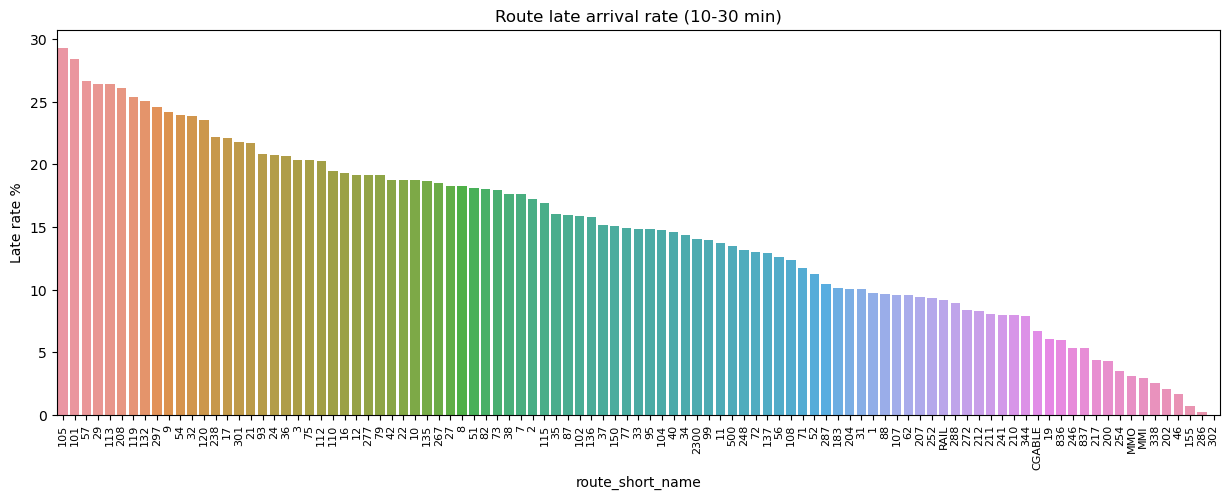

In [37]:
early2=early.groupby(['route_short_name','actual_date','trip_id'])['stop_id'].nunique().reset_index()
early3=early2.groupby(['route_short_name'])['stop_id'].sum().reset_index()
early_merge=veh_num2.merge(early3, on='route_short_name',how='left')
early_merge['early_rate']=early_merge['stop_id_y']*100/early_merge['stop_id_x']

plt.figure(figsize=(15,5))
seaborn.barplot(y="early_rate", x="route_short_name", data=early_merge, order=early_merge.sort_values(by=['early_rate'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Late rate %')
plt.title('Route late arrival rate (10-30 min)')
plt.savefig('Figure 8. Route 10-30 min late arrival rate.png')

30+ min late

In [38]:
early=df5[df5['status1']=='30+ min late']

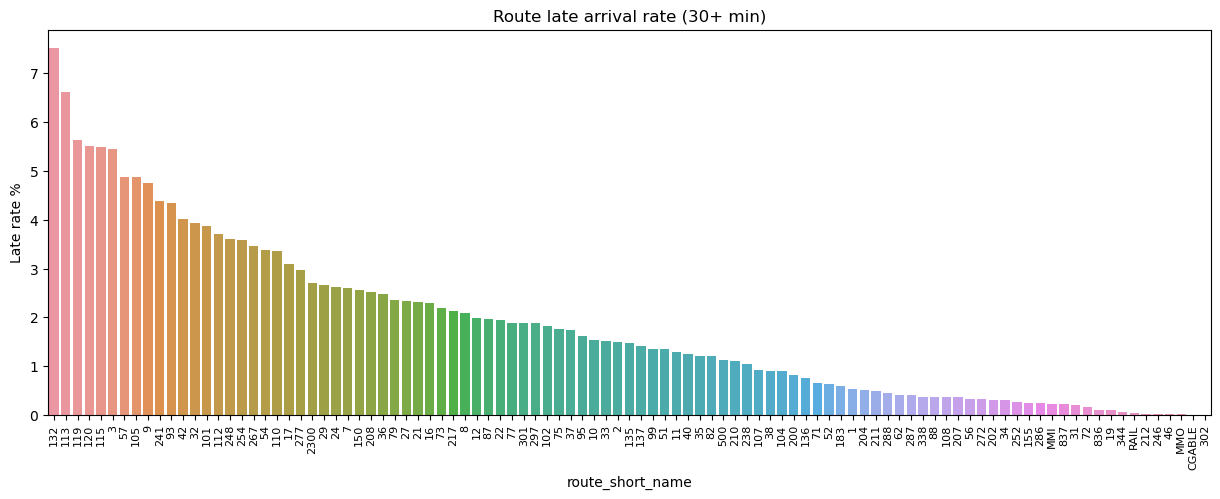

In [39]:
early2=early.groupby(['route_short_name','actual_date','trip_id'])['stop_id'].nunique().reset_index()
early3=early2.groupby(['route_short_name'])['stop_id'].sum().reset_index()
early_merge=veh_num2.merge(early3, on='route_short_name',how='left')
early_merge['early_rate']=early_merge['stop_id_y']*100/early_merge['stop_id_x']

plt.figure(figsize=(15,5))
seaborn.barplot(y="early_rate", x="route_short_name", data=early_merge, order=early_merge.sort_values(by=['early_rate'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('Late rate %')
plt.title('Route late arrival rate (30+ min)')
plt.savefig('Figure 8. Route 30+ min late arrival rate.png')

## dedicated routes 38, 51, and 120 

In [40]:
dedicated=['38','51','120']
dedicated=df5[df5['route_short_name'].map(str).isin(dedicated)]

In [41]:
dedicated.groupby(['route_short_name'])['headway_diff'].mean().reset_index()

,route_short_name,headway_diff
0,120,0.224940
1,38,-0.107608
2,51,0.100731


In [42]:
trip_num=dedicated.groupby(['actual_date','route_short_name'])['trip_id'].nunique().reset_index()
trip_num.groupby(['route_short_name'])['trip_id'].mean().reset_index()

,route_short_name,trip_id
0,120,108.087912
1,38,130.176796
2,51,77.125000


In [43]:
peak_hr=[6,7,8,9,16,17,18,19]
dedicated_pk=dedicated[dedicated['hourOfTimestamp1'].isin(peak_hr)]

trip_num=dedicated_pk.groupby(['actual_date','route_short_name'])['trip_id'].nunique().reset_index()
trip_num.groupby(['route_short_name'])['trip_id'].mean().reset_index()

,route_short_name,trip_id
0,120,65.560440
1,38,74.270718
2,51,56.210938


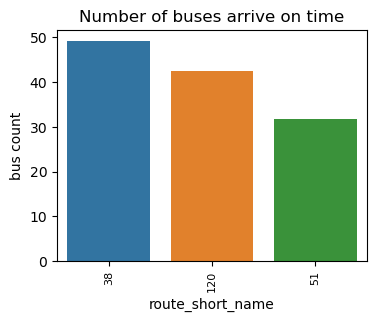

In [44]:
ontime=dedicated[dedicated['status1']=='on time']

ontime1=ontime.groupby(['actual_date','route_short_name'])['vehicle_id'].nunique().reset_index()
ontime2=ontime1.groupby(['route_short_name'])['vehicle_id'].mean().reset_index()

plt.figure(figsize=(4,3))
seaborn.barplot(y="vehicle_id", x="route_short_name", data=ontime2, order=ontime2.sort_values(by=['vehicle_id'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('bus count')
plt.title('Number of buses arrive on time')

plt.savefig('Figure 8. Route 30+ min late arrival rate.png')

Text(0.5, 1.0, 'Number of buses arrive 2-5 min late')

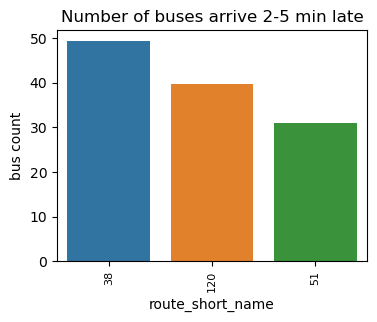

In [45]:
ontime=dedicated[dedicated['status1']=='2-5 min late']

ontime1=ontime.groupby(['actual_date','route_short_name'])['vehicle_id'].nunique().reset_index()
ontime2=ontime1.groupby(['route_short_name'])['vehicle_id'].mean().reset_index()

plt.figure(figsize=(4,3))
seaborn.barplot(y="vehicle_id", x="route_short_name", data=ontime2, order=ontime2.sort_values(by=['vehicle_id'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('bus count')
plt.title('Number of buses arrive 2-5 min late')

Text(0.5, 1.0, 'Number of buses arrive 5-10 min late late')

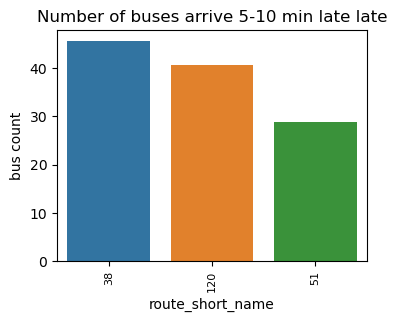

In [46]:
ontime=dedicated[dedicated['status1']=='5-10 min late']

ontime1=ontime.groupby(['actual_date','route_short_name'])['vehicle_id'].nunique().reset_index()
ontime2=ontime1.groupby(['route_short_name'])['vehicle_id'].mean().reset_index()

plt.figure(figsize=(4,3))
seaborn.barplot(y="vehicle_id", x="route_short_name", data=ontime2, order=ontime2.sort_values(by=['vehicle_id'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('bus count')
plt.title('Number of buses arrive 5-10 min late late')

Text(0.5, 1.0, 'Number of buses arrive 10-30 min late late')

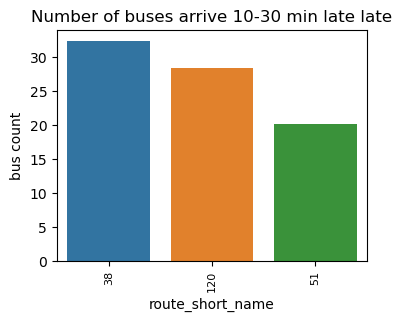

In [47]:
ontime=dedicated[dedicated['status1']=='10-30 min late']

ontime1=ontime.groupby(['actual_date','route_short_name'])['vehicle_id'].nunique().reset_index()
ontime2=ontime1.groupby(['route_short_name'])['vehicle_id'].mean().reset_index()

plt.figure(figsize=(4,3))
seaborn.barplot(y="vehicle_id", x="route_short_name", data=ontime2, order=ontime2.sort_values(by=['vehicle_id'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('bus count')
plt.title('Number of buses arrive 10-30 min late late')

Text(0.5, 1.0, 'Number of buses arrive 30+ min late late')

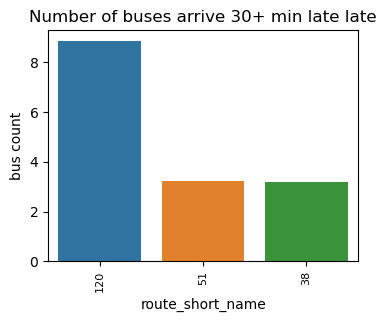

In [48]:
ontime=dedicated[dedicated['status1']=='30+ min late']

ontime1=ontime.groupby(['actual_date','route_short_name'])['vehicle_id'].nunique().reset_index()
ontime2=ontime1.groupby(['route_short_name'])['vehicle_id'].mean().reset_index()

plt.figure(figsize=(4,3))
seaborn.barplot(y="vehicle_id", x="route_short_name", data=ontime2, order=ontime2.sort_values(by=['vehicle_id'], ascending=False).set_index('route_short_name').index)
plt.xticks(rotation=90,fontsize=8)
plt.ylabel('bus count')
plt.title('Number of buses arrive 30+ min late late')

## correlation with route length

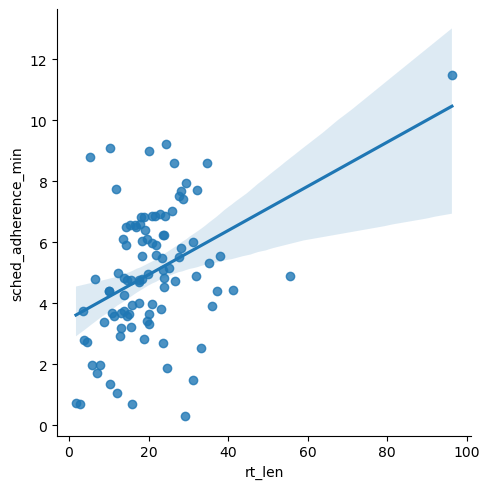

In [49]:
#average wait time by route
df5_mean=df5.groupby(['route_short_name'])['sched_adherence_min'].mean().reset_index()

rt_len2.rename(columns = {'route_shor':'route_short_name'}, inplace = True)

df5_mean_len=df5_mean.merge(rt_len2,on='route_short_name', how='left').dropna()

#df5_mean_len.rename(columns = {'sched_adherence_min':'wait_time'}, inplace = True)

seaborn.lmplot(x="rt_len", y="sched_adherence_min", data=df5_mean_len)

## System on-time performance overview

<AxesSubplot: xlabel='hourOfTimestamp2'>

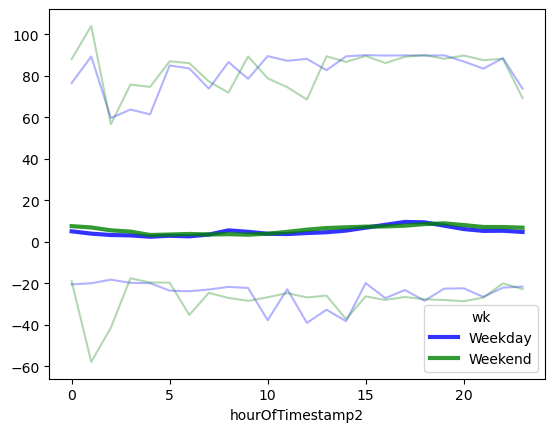

In [50]:
grouped = df5.groupby(['wk','hourOfTimestamp2']).agg({'sched_adherence_min': ['min', 'mean', 'max']}).unstack("wk")

colors = ['b','g','r']
ax=grouped.loc[:,('sched_adherence_min', 'mean')].plot(color=colors, alpha=0.8, linewidth=3)
grouped.loc[:,('sched_adherence_min', 'max')].plot(ax=ax,color=colors,legend=False, alpha=0.3)
grouped.loc[:,('sched_adherence_min', 'min')].plot(ax=ax,color=colors,legend=False, alpha=0.3)

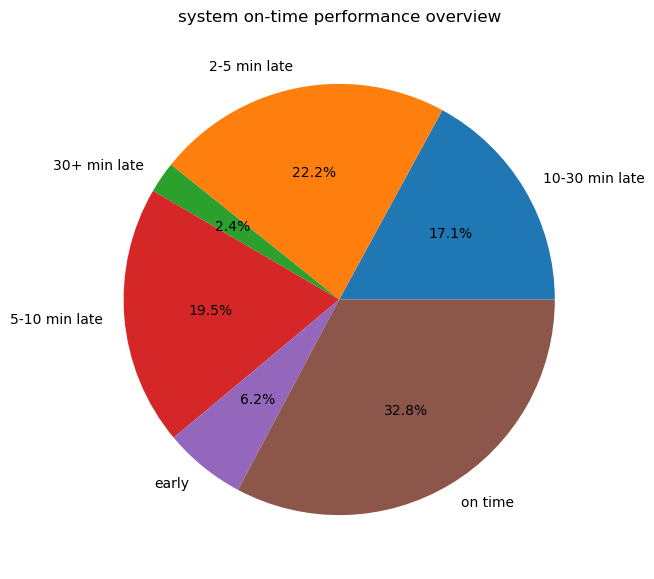

In [51]:
group2=df5.groupby(['status1']).size().reset_index()
group2=group2.rename(columns={0: "status_cnt"})

group2['percent']=100*group2['status_cnt']/(group2['status_cnt'].sum())

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(group2.percent,labels=group2.status1, autopct='%.1f%%')
plt.title('system on-time performance overview')
# show plot
plt.show()


In [54]:
df5= pd.concat([df5,pd.DataFrame(columns=['mode'])], sort=False)

metromover=['MMO', 'MMI']
trolly=['CGABLE']
rail=['RAIL']
bus=['MMO', 'MMI', 'CGABLE', '1', '2', '3', '7', '8', '9', '10', '11',
       '12', '16', '17', '19', '21', '22', '24', '27', '29', '31', '32',
       '33', '34', '35', '36', '37', '38', '40', '42', '46', '51', '52',
       '54', '56', '57', '62', '71', '72', '73', '75', '77', '79', '82',
       '87', '88', '93', '99', '101', '102', '104', '105', '107', '108',
       '110', '112', '113', '115', '119', '120', '132', '135', '136',
       '137', '150', '155', '183', '200', '202', '204', '207', '208',
       '210', '211', '212', '217', '238', '241', '246', '248', '252',
       '254', '267', '272', '277', '286', '287', '288', '297', '301',
       '302', '338', '344', '500', '836', '837', '95', '2300']

df5['mode'][df5['route_short_name'].isin(list(bus))]='bus'
df5['mode'][df5['route_short_name'].isin(list(rail))]='rail'
df5['mode'][df5['route_short_name'].isin(list(trolly))]='trolly'
df5['mode'][df5['route_short_name'].isin(list(metromover))]='metromover'

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\4043665883.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['mode'][df5['route_short_name'].isin(list(bus))]='bus'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\4043665883.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['mode'][df5['route_short_name'].isin(list(rail))]='rail'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\4043665883.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

bus

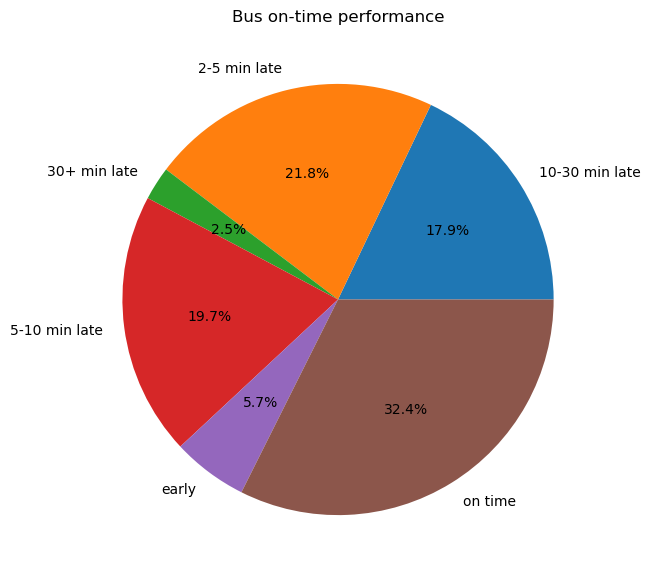

In [55]:
bus=df5[df5['mode']=='bus']

group2=bus.groupby(['status1']).size().reset_index()
group2=group2.rename(columns={0: "status_cnt"})

group2['percent']=100*group2['status_cnt']/(group2['status_cnt'].sum())

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(group2.percent,labels=group2.status1, autopct='%.1f%%')
plt.title('Bus on-time performance')
# show plot
plt.show()

rail

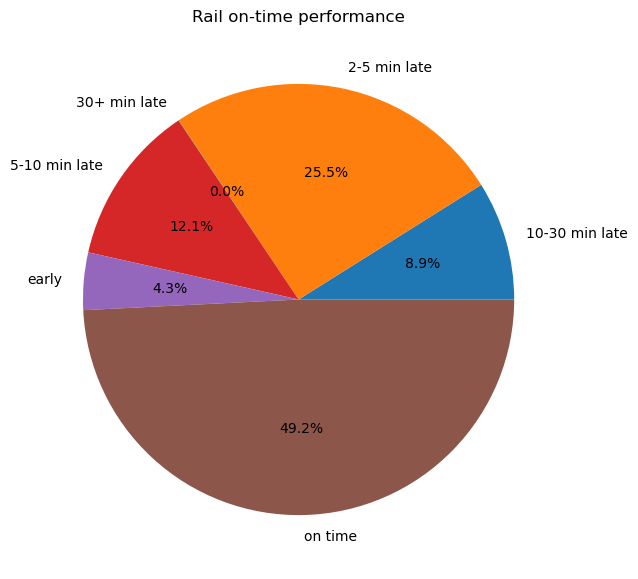

In [56]:
bus=df5[df5['mode']=='rail']

group2=bus.groupby(['status1']).size().reset_index()
group2=group2.rename(columns={0: "status_cnt"})

group2['percent']=100*group2['status_cnt']/(group2['status_cnt'].sum())

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(group2.percent,labels=group2.status1, autopct='%.1f%%')
plt.title('Rail on-time performance')
# show plot
plt.show()

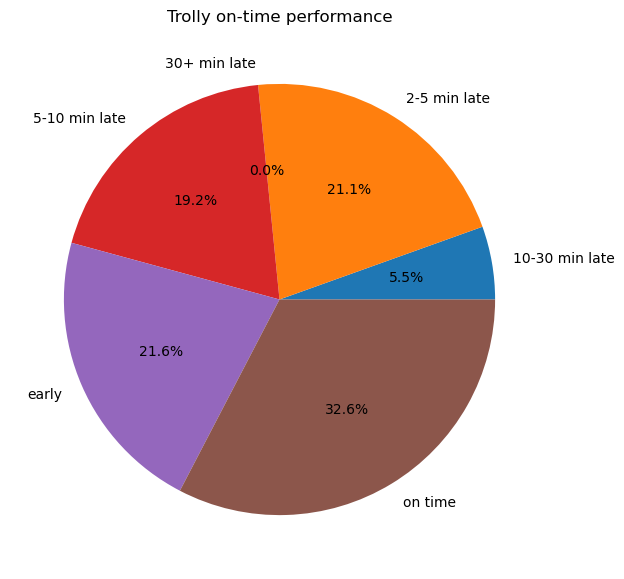

In [57]:
bus=df5[df5['mode']=='trolly']

group2=bus.groupby(['status1']).size().reset_index()
group2=group2.rename(columns={0: "status_cnt"})

group2['percent']=100*group2['status_cnt']/(group2['status_cnt'].sum())

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(group2.percent,labels=group2.status1, autopct='%.1f%%')
plt.title('Trolly on-time performance')
# show plot
plt.show()

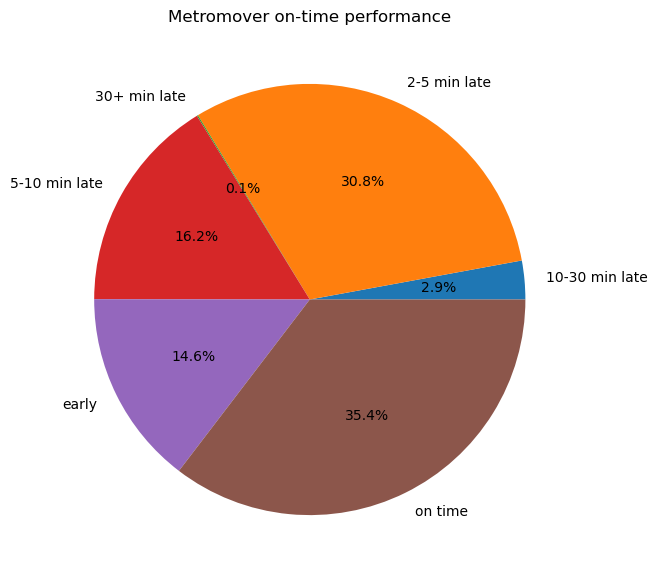

In [58]:
bus=df5[df5['mode']=='metromover']

group2=bus.groupby(['status1']).size().reset_index()
group2=group2.rename(columns={0: "status_cnt"})

group2['percent']=100*group2['status_cnt']/(group2['status_cnt'].sum())

# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(group2.percent,labels=group2.status1, autopct='%.1f%%')
plt.title('Metromover on-time performance')
# show plot
plt.show()

### Arrival time differences by route types

In this section, the arrival time differences are measured by different route types, including transit modes, operators and routes with different headways in Figure 13. Among different transit modes, bus has the highest variation of arrival time difference and average highest arrival time difference at about six minutes, since bus occupies the highest proportion among all transit modes. Other travel modes have relatively smaller variation and lower average arrival time difference, which is lower than 3 minutes. 

These routes can then be categorized based on the headways (0-10 min, 10-20 min, 20-30 min, 30-40 min and 40+ min). The routes with the highest headways (40+ min) also have the higher average arrival time difference with higher variation, while routes with 10-20 min headway have the smallest arrival time difference with smaller variation. 

Private and public routes are categorized: 1, 29, 46, 56, 71, 72, 82, 101(A), 115,155, 202, 210, 211, 212, 217, 246, 248, 254, 267, 272, 286, and 344 are privatized routes while others are public. Both the average arrival time difference and the variation of private routes is slightly smaller than the public routes. 


(array([0, 1, 2, 3]),
 [Text(0, 0, 'metromover'),
  Text(1, 0, 'trolly'),
  Text(2, 0, 'bus'),
  Text(3, 0, 'rail')])

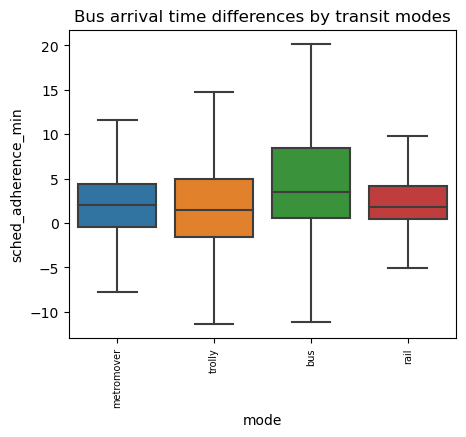

In [59]:
plt.figure(figsize=(5,4))
seaborn.boxplot(x="mode", y="sched_adherence_min", data=df5, showfliers = False)
plt.title("Bus arrival time differences by transit modes")
locs, labels = plt.xticks()
plt.xticks(rotation=90,fontsize=7)

**By headway**

In [60]:
df5= pd.concat([df5,pd.DataFrame(columns=['headway_cat'])], sort=False)

<AxesSubplot: ylabel='Frequency'>

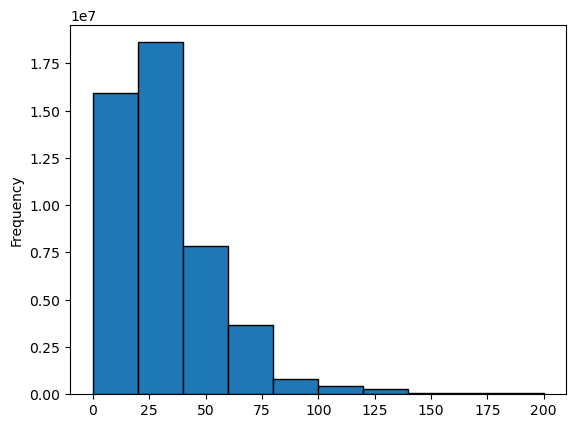

In [61]:
df5['interval2'].plot(kind='hist', edgecolor='black')

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3981339906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['headway_cat'][df5['interval2']<=10]='0-10 min'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3981339906.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['headway_cat'][(df5['interval2']>10)&(df5['interval2']<=20)]='10-20 min'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\3981339906.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

<AxesSubplot: xlabel='headway_cat'>

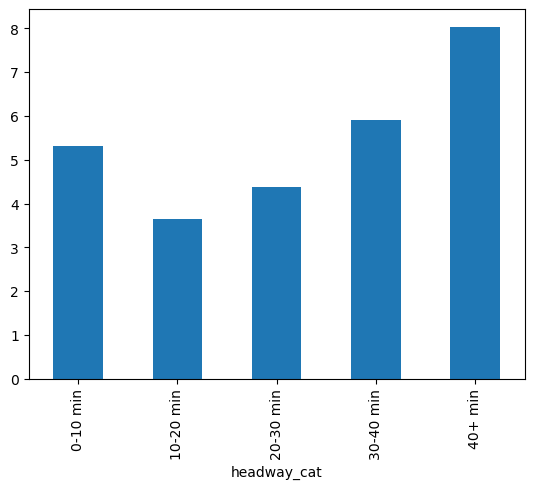

In [62]:
df5['headway_cat'][df5['interval2']<=10]='0-10 min'
df5['headway_cat'][(df5['interval2']>10)&(df5['interval2']<=20)]='10-20 min'
df5['headway_cat'][(df5['interval2']>20)&(df5['interval2']<=30)]='20-30 min'
df5['headway_cat'][(df5['interval2']>30)&(df5['interval2']<=40)]='30-40 min'
df5['headway_cat'][df5['interval2']>40]='40+ min'

df5.groupby(['headway_cat'])['sched_adherence_min'].mean().plot(kind='bar')

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '0-10 min'),
  Text(1, 0, '20-30 min'),
  Text(2, 0, '10-20 min'),
  Text(3, 0, '30-40 min'),
  Text(4, 0, '40+ min')])

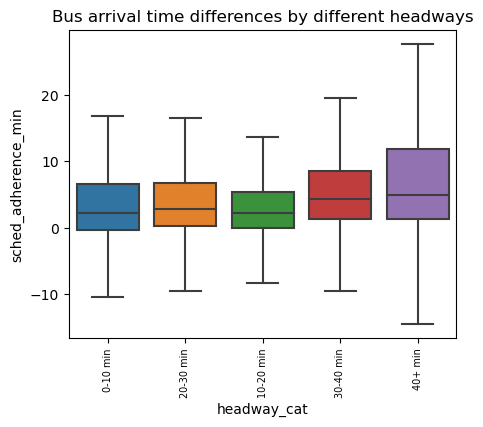

In [63]:
plt.figure(figsize=(5,4))
seaborn.boxplot(x="headway_cat", y="sched_adherence_min", data=df5, showfliers = False)
plt.title("Bus arrival time differences by different headways")
locs, labels = plt.xticks()
plt.xticks(rotation=90,fontsize=7)

**By Operator type**

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\725120558.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['operator'][df5['route_short_name'].isin(list(private))]='private'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\725120558.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['operator'][~df5['route_short_name'].isin(list(private))]='public'


<AxesSubplot: xlabel='operator'>

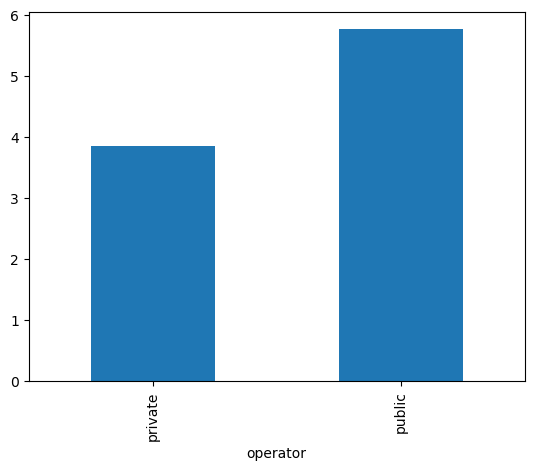

In [64]:
df5= pd.concat([df5,pd.DataFrame(columns=['operator'])], sort=False)

private=['1','29','46','56','71','72','82','101','115','155','202','210','211','212','217','246','248','254','267','272','286','344']

df5['operator'][df5['route_short_name'].isin(list(private))]='private'
df5['operator'][~df5['route_short_name'].isin(list(private))]='public'

df5.groupby(['operator'])['sched_adherence_min'].mean().plot(kind='bar')

(array([0, 1]), [Text(0, 0, 'public'), Text(1, 0, 'private')])

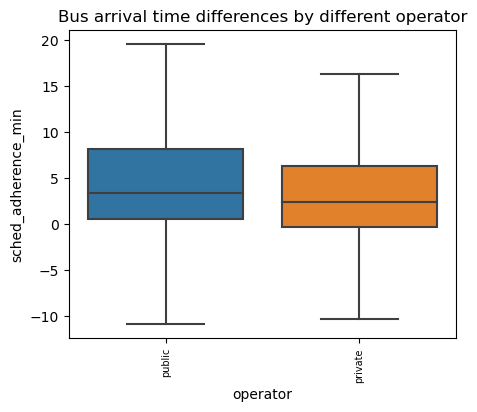

In [65]:
plt.figure(figsize=(5,4))
seaborn.boxplot(x="operator", y="sched_adherence_min", data=df5, showfliers = False)
plt.title("Bus arrival time differences by different operator")
locs, labels = plt.xticks()
plt.xticks(rotation=90,fontsize=7)

### Early or late arrival rate by stops 

In [66]:

# add a new column to identify whether it's late or early
df5= pd.concat([df5,pd.DataFrame(columns=['status'])], sort=False)

#define early or late +- 5min 
df5['status'][df5['sched_adherence_secs']<=-300]='early'
df5['status'][df5['sched_adherence_secs']>=300]='late'

C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\1348996203.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['status'][df5['sched_adherence_secs']<=-300]='early'
C:\Users\anranzheng\AppData\Local\Temp\ipykernel_5312\1348996203.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df5['status'][df5['sched_adherence_secs']>=300]='late'


In [67]:
df5['status'].value_counts()

late     18584780
early      472923
Name: status, dtype: int64

At stop level 

C:\Users\anranzheng\Anaconda3\envs\geo\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


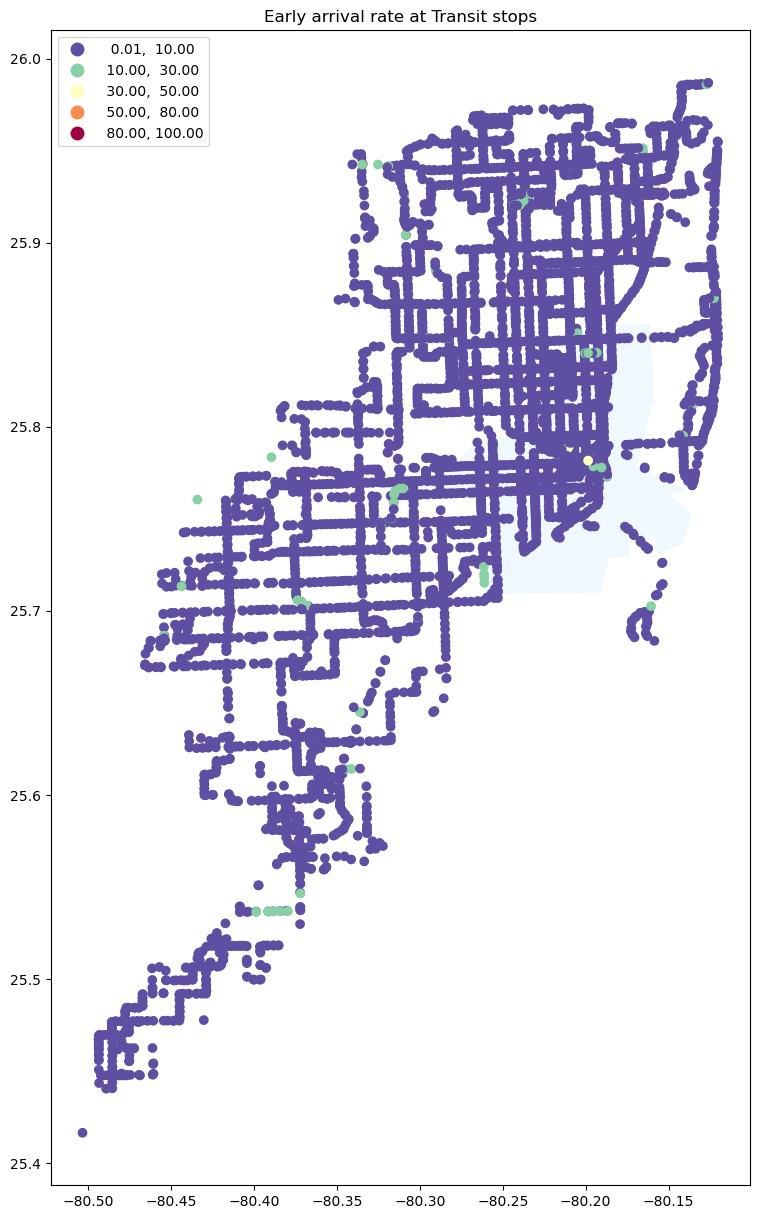

In [68]:
weekend=df5[df5['wk']=='Weekend']
weekday=df5[df5['wk']=='Weekday']

stop_df=df5.groupby('stop_id').size().reset_index()
stop_df=stop_df.rename(columns={0: "stop_cnt"})

import pyogrio
#next step: merge the stop lat, lon info to the stopID
stop_info=pd.read_csv('..//miami data//merge_schedule.csv')[['stop_id','stop_lat','stop_lon']]

jax_boundary= gpd.read_file('C:/Users/anranzheng/Downloads/Miami_City_District/Miami_City_District.shp')
#route= gpd.read_file('C:/Users/anranzheng/Downloads/miami Bus_Route/Bus_Route.shp')

weekend=df5

#weekend
status_df2=weekend.groupby(['stop_id','status']).size().reset_index()
status_df2=status_df2.rename(columns={0: "status_cnt"})

#left join
stop_group = pd.merge(status_df2, stop_df, how='left', on='stop_id')

stop_group['%']=100*stop_group['status_cnt']/stop_group['stop_cnt']

#left join
stop = pd.merge(stop_group, stop_info, how='left', on='stop_id')

stop=stop.drop_duplicates()

crs={'init':'epsg:4326'}
geometry=[Point(xy) for xy in zip(stop['stop_lon'],stop['stop_lat'])]
geo_df=gpd.GeoDataFrame(stop,crs=crs,geometry=geometry)

early=geo_df[geo_df['status']=='early']

#create spatial distribution of delays
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
jax_boundary.plot(ax=ax, color='aliceblue', label='boundary')
#route.plot(ax=ax, color='grey', label='route', linewidth=0.1)
early.plot(ax=ax, marker='o', column='%', legend=True, cmap='Spectral_r', scheme="User_Defined",classification_kwds=dict(bins=[10,30,50,80,100]))
#plt.title('Early arrival rate at Transit stops at Weekend (%)')
plt.title('Early arrival rate at Transit stops')
plt.savefig('Figure 14. Early arrival rate at stop level.png')

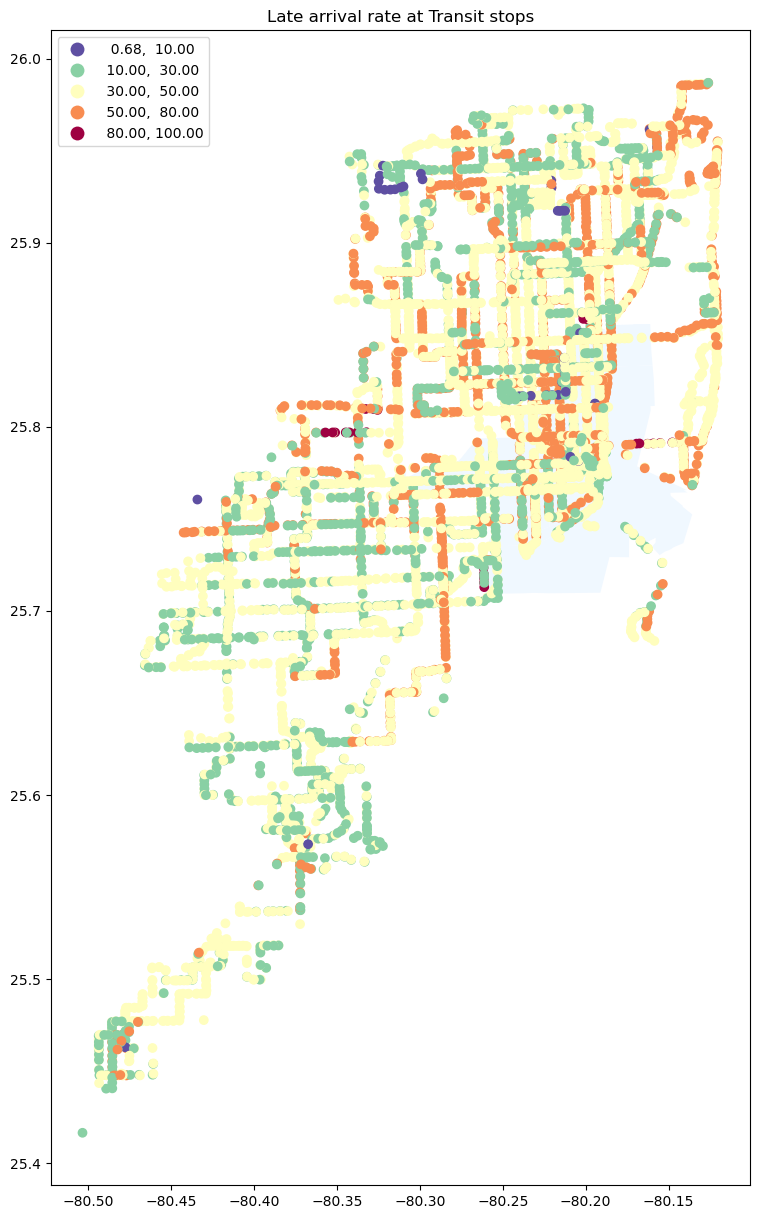

In [69]:
late=geo_df[geo_df['status']=='late']

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
jax_boundary.plot(ax=ax, color='aliceblue', label='boundary')
#route.plot(ax=ax, color='grey', label='route', linewidth=0.1)
late.plot(ax=ax, marker='o', column='%', legend=True, cmap='Spectral_r', scheme="User_Defined",classification_kwds=dict(bins=[10,30,50,80,100]))
#plt.title('Late arrival rate at Transit stops at Weekend (%)')
plt.title('Late arrival rate at Transit stops')
plt.savefig('Figure 14. Late arrival rate at stop level.png')

# Headway difference

A second measurement of on-time performance assesses the difference between actual headway and scheduled headway (to be termed as headway difference). The headway is calculated by finding the time difference between two continuous trips with the same destination, passing by the same stop on the same route and on the same date. The headway difference measures the experience for passengers who do not check the transit schedule but have some sense of the headway of the routes they take. If the transit system has perfect on-time performance, the headway difference value should be close to 0 with little variation (i.e., the actual bus operation strictly follows its schedule).

In [70]:
weekend=df5[df5['wk']=='Weekend']
weekday=df5[df5['wk']=='Weekday']

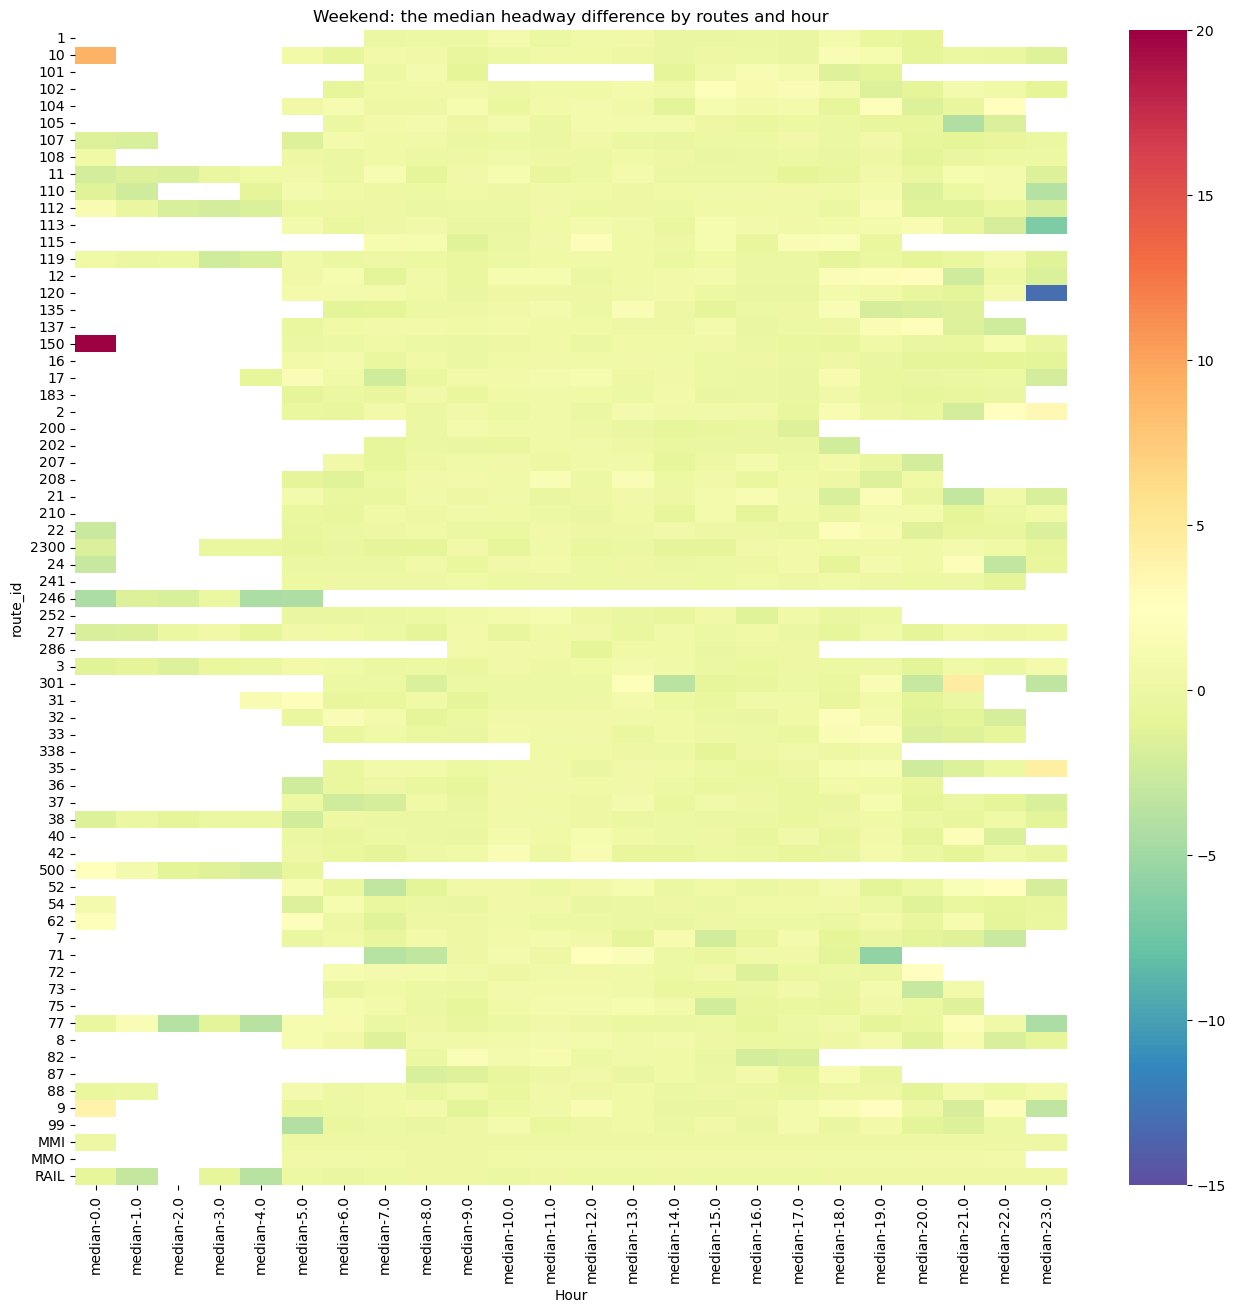

In [72]:
#schedule 
plt.figure(figsize=(16,15))
schedule = weekend.pivot_table(index=weekend.route_short_name, columns=weekend.hourOfTimestamp2, aggfunc=[np.median],values="headway_diff")
seaborn.heatmap(schedule, cmap='Spectral_r', vmin=-15, vmax=20)
plt.title('Weekend: the median headway difference by routes and hour')
plt.xlabel('Hour')
plt.ylabel('route_id')
plt.savefig('Figure 17. pivot table of mean headway differences (weekend).png')
plt.show() 

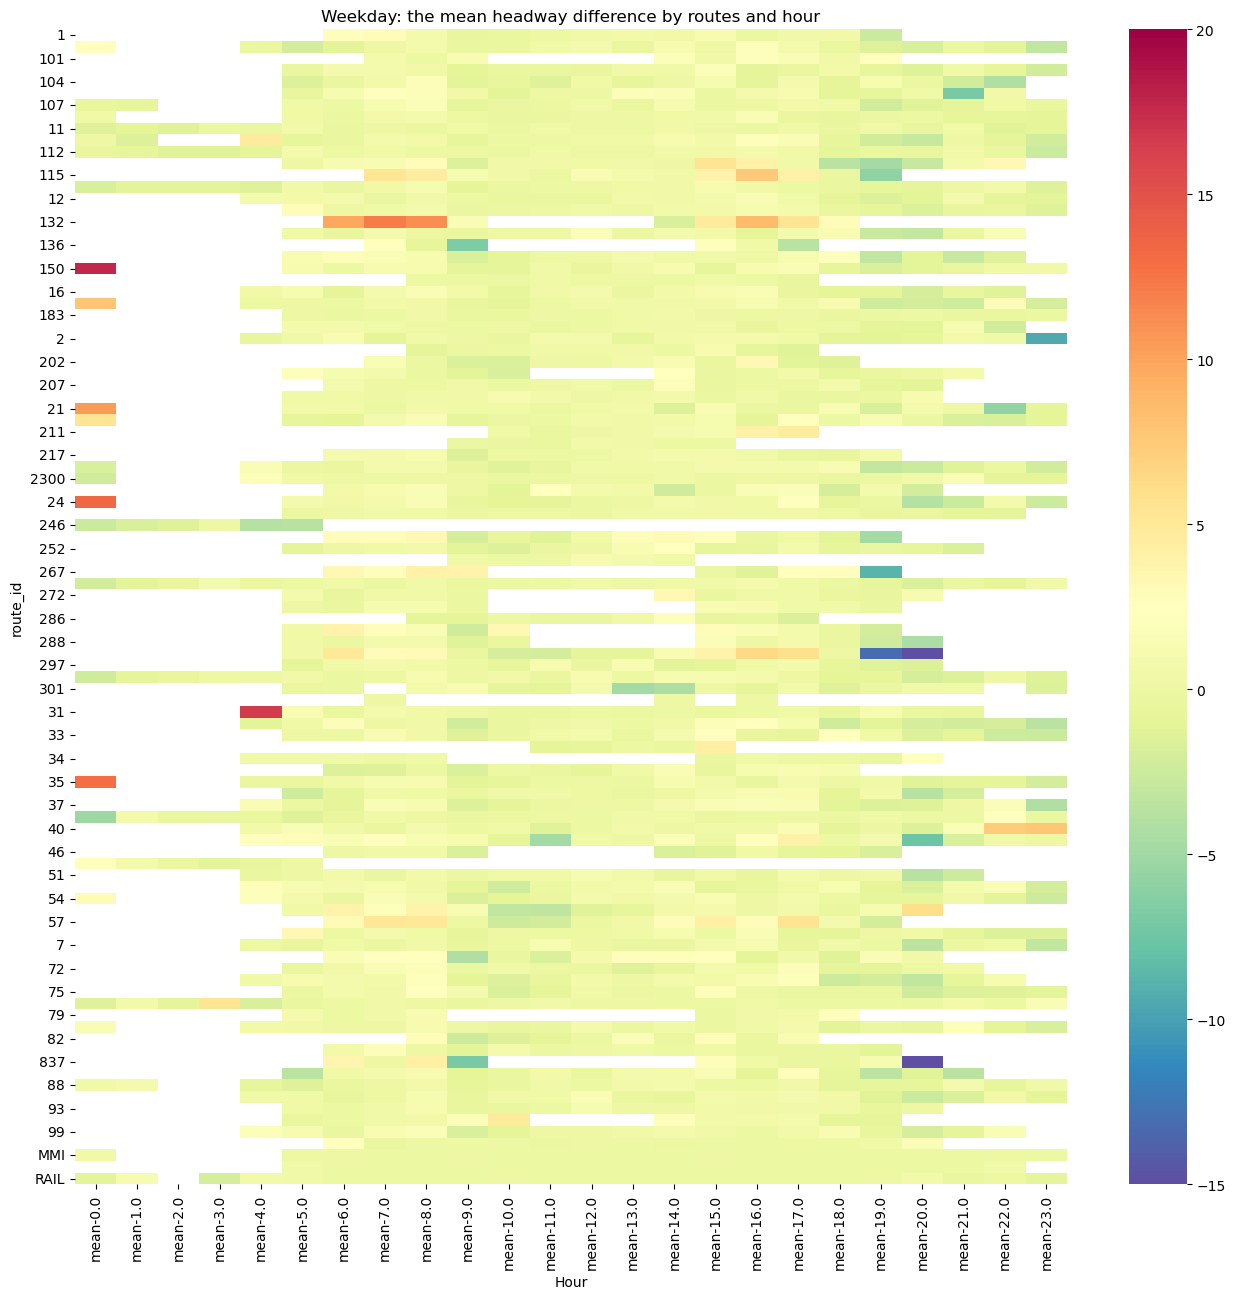

In [73]:
#schedule 
plt.figure(figsize=(16,15))
schedule = weekday.pivot_table(index=weekday.route_short_name, columns=weekday.hourOfTimestamp2, aggfunc=[np.mean],values="headway_diff")
seaborn.heatmap(schedule, cmap='Spectral_r', vmin=-15, vmax=20)
plt.title('Weekday: the mean headway difference by routes and hour')
plt.xlabel('Hour')
plt.ylabel('route_id')
plt.savefig('weekend headway diff.png')
plt.show() 

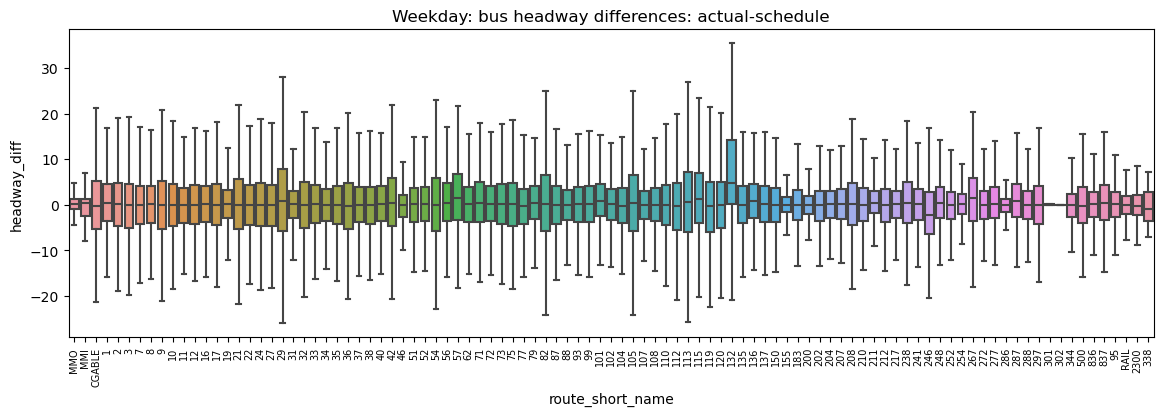

In [74]:
plt.figure(figsize=(14,4))
seaborn.boxplot(x="route_short_name", y="headway_diff", data=weekday, showfliers = False)
plt.title("Weekday: bus headway differences: actual-schedule")
locs, labels = plt.xticks()
plt.xticks(rotation=90,fontsize=7)
plt.savefig('Figure 16. the headway difference at weekdays.png')

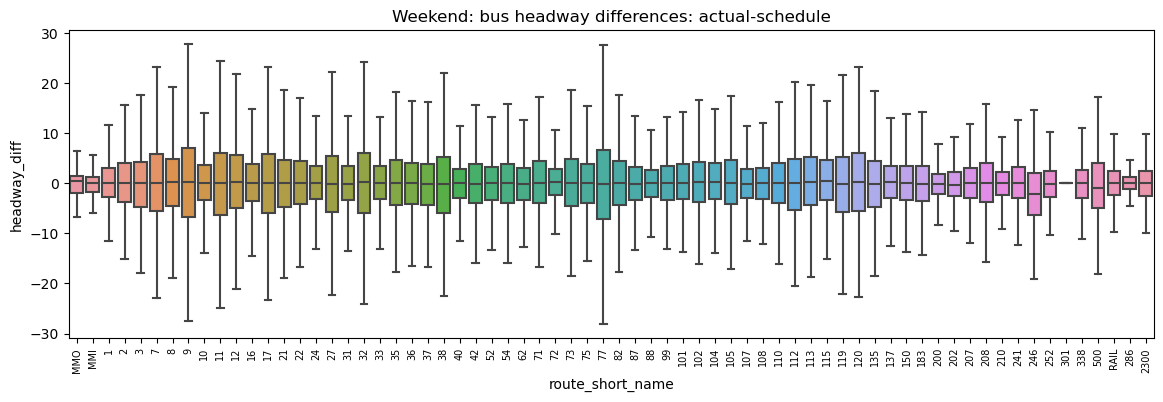

In [75]:
plt.figure(figsize=(14,4))
seaborn.boxplot(x="route_short_name", y="headway_diff", data=weekend, showfliers = False)
plt.title("Weekend: bus headway differences: actual-schedule")
locs, labels = plt.xticks()
plt.xticks(rotation=90,fontsize=7)
plt.savefig('Figure 16. the headway difference at weekend.png')